In [1]:
import pandas as pd
from ztfrapid import ztf_rapid
import numpy as np
from scipy.stats import binned_statistic
import seaborn as sns

You will need to install 'emcee' if you wish to train your own classifier on new data.


In [2]:
lc_data_path = '/home/nmiranda/workspace/ztf_rapid/data/raw/rcf_marshallc_sncosmo_200114_2018classupdate_addedcv.pkl'
lc_data = pd.read_pickle(lc_data_path)

In [3]:
all_mag = np.concatenate([ztf_rapid.get_mag(lc) for lc in lc_data.values()])
all_mag_err = np.concatenate([ztf_rapid.get_mag_err(lc) for lc in lc_data.values()])
real_data = pd.DataFrame({'mag': all_mag, 'magErr': all_mag_err, 'type': 'Real'})

In [4]:
all_sim_lc = [ztf_rapid.ztf_noisify(lc, lc.meta['z'] * 2.0) for lc in lc_data.values() if lc.meta['z'] is not None]
sim_mag = np.concatenate([ztf_rapid.get_mag(lc) for lc in all_sim_lc if len(lc) > 0])
sim_mag_err = np.concatenate([ztf_rapid.get_mag_err(lc) for lc in all_sim_lc if len(lc) > 0])
sim_data = pd.DataFrame({'mag': sim_mag, 'magErr': sim_mag_err, 'type': 'Simulated'})

In [5]:
sim_data_subset = sim_data[(sim_data['magErr'] > 0.0) & (sim_data['magErr'] < 0.5)]
print(sim_data_subset.shape)
real_data_subset = real_data[(real_data['magErr'] > 0.0) & (real_data['magErr'] < 0.5)]
print(real_data_subset.shape)
sel_num = 50000
# sel_num = 1000
all_data_subset = pd.concat([real_data_subset[:sel_num], sim_data_subset[:sel_num]])
print(all_data_subset.shape)

(151997, 3)
(183869, 3)
(100000, 3)


In [6]:
range_min = all_data_subset['mag'].min()
range_max = all_data_subset['mag'].max()
print(range_min, range_max)

14.589999999999998 23.847925014038825


In [7]:
real_bin_means, real_bin_edges, real_binnumber = binned_statistic(
    real_data_subset['mag'], 
    real_data_subset['magErr'],
    statistic='mean',
    range=(range_min, range_max),
)
real_bin_stds, _, _ = binned_statistic(
    real_data_subset['mag'], 
    real_data_subset['magErr'],
    statistic='std',
    range=(range_min, range_max),
)
real_bin_width = (real_bin_edges[1] - real_bin_edges[0])
real_bin_centers = real_bin_edges[1:] - real_bin_width/2
print(len(real_bin_centers))
print(len(real_bin_means))

10
10


In [8]:
sim_bin_means, sim_bin_edges, sim_binnumber = binned_statistic(
    sim_data_subset['mag'], 
    sim_data_subset['magErr'],
    statistic='mean',
    range=(range_min, range_max),
)
sim_bin_stds, _, _ = binned_statistic(
    sim_data_subset['mag'], 
    sim_data_subset['magErr'],
    statistic='std',
    range=(range_min, range_max),
)
sim_bin_width = (sim_bin_edges[1] - sim_bin_edges[0])
sim_bin_centers = sim_bin_edges[1:] - sim_bin_width/2
sim_bin_centers = sim_bin_centers + 0.08
print(len(sim_bin_centers))
print(len(sim_bin_means))

10
10


<ErrorbarContainer object of 3 artists>

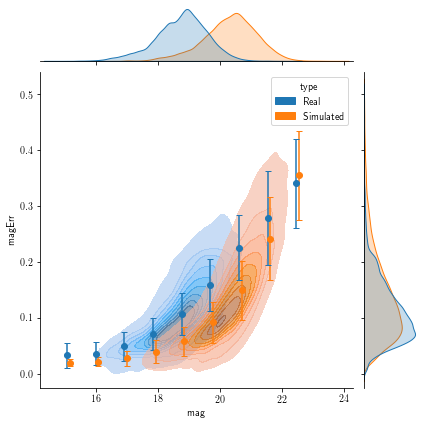

In [9]:
g = sns.jointplot(
    data=all_data_subset, 
    x='mag', 
    y='magErr', 
    hue='type', 
    kind='kde',
#     kind='scatter',
    fill=True,
#     ylim=(-0.05, 0.5),
#     xlim=(16, 24),
    alpha=0.6,
    legend='False',
)

#
g.ax_joint.errorbar(real_bin_centers[:8], real_bin_means[:8], yerr=real_bin_stds[:8], capsize=3.0, fmt='o')
g.ax_joint.errorbar(sim_bin_centers[:8], sim_bin_means[:8], yerr=sim_bin_stds[:8], capsize=3.0, fmt='o')
